In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import all the required libraries

#System libraries
import os, time
from tqdm import tqdm
import glob

# Data manipulation
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter

# Model building 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


#Read/Display  images
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

# import tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

In [ ]:
print("Tensorflow Version:",tf.__version__)
print("Keras Version     :",keras.__version__)

Tensorflow Version: 2.4.1
Keras Version     : 2.4.0


## Data understanding

#### Import the Flickr8k images and text dataset

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/Deep Learning Project/Flicker8k_Dataset'
CAPTIONS_FILE = '/content/drive/MyDrive/Deep Learning Project/captions.txt'

#### Import the dataset and read the image into a seperate variable

In [ ]:
images = '/content/drive/MyDrive/Deep Learning Project/Flicker8k_Dataset/'
all_imgs = glob.glob(images+ '*.jpg')
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


Explore Image dataset

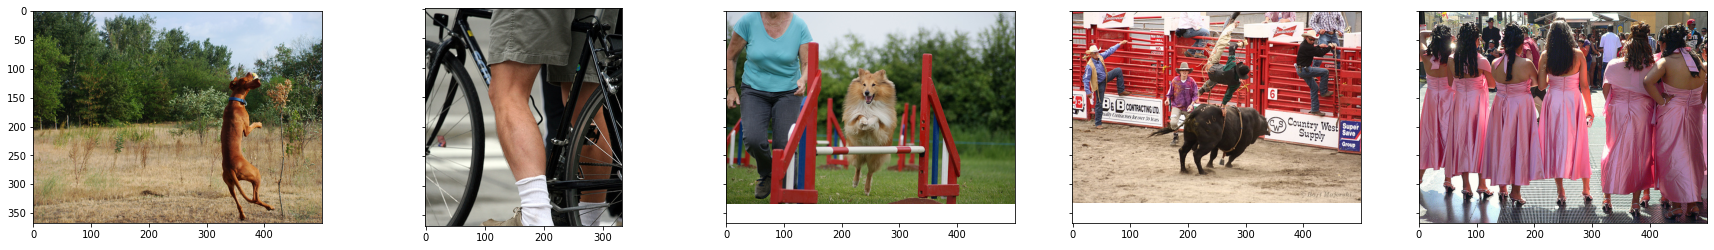

In [ ]:
def plot_image(images, cmap = None):
    f, axes = plt.subplots(1, len(images), sharey = True)
    f.set_figwidth(30,30)
    
    for ax, image in zip(axes, images):
        ax.imshow(io.imread(image), cmap)

plot_image(all_imgs[0:5])

Explore Captions dataset

In [ ]:
def load_document(filename):
    
    file = open(filename)
    text = file.read()
    file.close()
   
    return text

document = load_document(CAPTIONS_FILE)
print(document[:413])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin 


#### Create a dataframe which summarizes the image and captions

In [ ]:
def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(IMAGE_PATH+'/'+im_id)
    return keys,key_paths, values

In [ ]:
all_img_id, all_img_vector, annotations = get_img_ids_and_captions(document)

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head(10)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Deep Learning Project/F...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Deep Learning Project/F...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Deep Learning Project/F...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Deep Learning Project/F...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Deep Learning Project/F...,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,/content/drive/MyDrive/Deep Learning Project/F...,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,/content/drive/MyDrive/Deep Learning Project/F...,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,/content/drive/MyDrive/Deep Learning Project/F...,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,/content/drive/MyDrive/Deep Learning Project/F...,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,/content/drive/MyDrive/Deep Learning Project/F...,Two dogs on pavement moving toward each other .


Since each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


#### Visualise both the images & text present in the Dataframe created above

In [ ]:
def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)

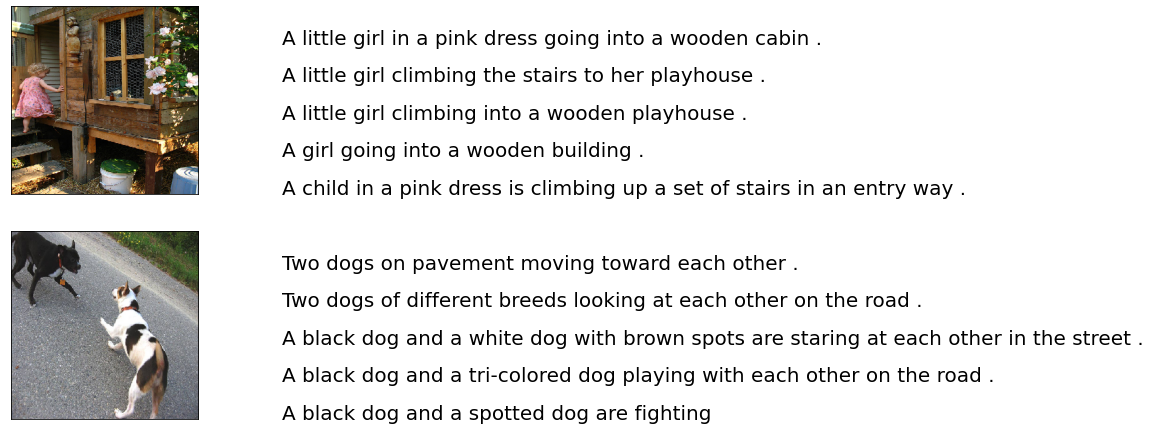

In [ ]:
fig = plt.figure(figsize=(10,20))
count = 1 
for Path in df[:10].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

How many unique files are there?

In [ ]:
uni_filenames= np.unique(df.ID.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:", Counter(Counter(df.ID.values).values()))

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


#### Create the vocabulary and the counter for the captions. 
This would help us to know how many times each word is repeated

In [ ]:
def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out

vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

#### Creating a dataframe for the word and its count

In [ ]:
df_word = pd.DataFrame.from_dict(val_count, orient = 'index')
df_word = df_word.sort_values(by = [0], ascending=False).reset_index()
df_word = df_word.rename(columns={'index':'word', 0:'count'})
df_word.head(30)

,word,count
0,a,40271
1,.,34212
2,A,21481
3,in,18961
4,the,15328
5,on,10729
6,is,9345
7,and,8850
8,dog,7982
9,with,7760


#### Visualise the top 30 occuring words in the captions

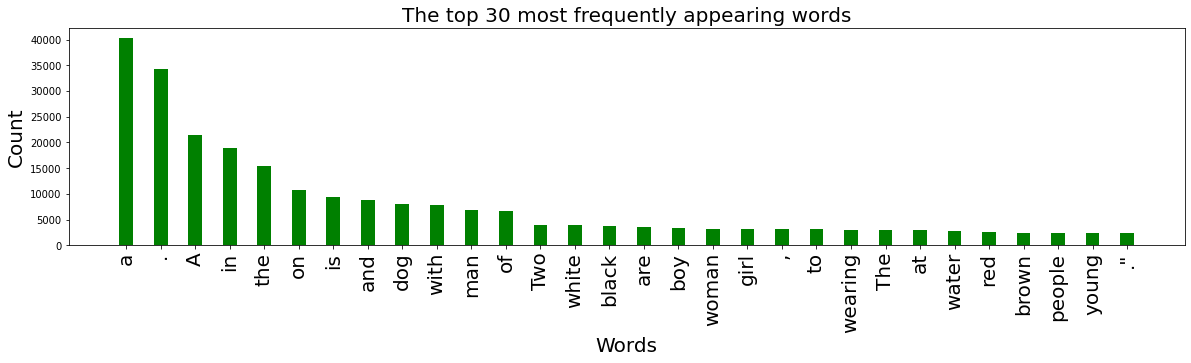

In [ ]:
def plthist(index,words,count, title="The top 30 most frequently appearing words"):
    plt.figure(figsize=(20,4))
    plt.bar(words,count,color='Green', width =0.4)
    plt.xlabel("Words",  fontsize=20) 
    plt.ylabel("Count",rotation=90,fontsize=20) 
   # plt.yticks(fontsize=20)
    plt.xticks(index,words,rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
words = list(df_word[:30].word)

count =list(df_word['count'][:30])
plthist(list(range(0,30)),words,count)

## Pre-Processing

### Pre-Processing the captions


#### Padding <start> and <end> to all the captions

In [ ]:
annotations = df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>")
all_img_path = df.Path.to_list()
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


#### Create a Tokenizer:
Will create tokenized vectors by tokenizing the captions. To do this, we will split the texts using spaces & other filters. This gives us a vocabulary of all of the unique words in the data. Inorder to Keep saving memory we will keep total vocaublary to top 5,000 words

In [ ]:
# create the tokenizer
top_word_cnt = 6000
special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,
                                                  oov_token="<unk>",
                                                  filters=special_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [ ]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 5160, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [ ]:
annotations[:5]

0    <start> A child in a pink dress is climbing up...
1    <start> A girl going into a wooden building . ...
2    <start> A little girl climbing into a wooden p...
3    <start> A little girl climbing the stairs to h...
4    <start> A little girl in a pink dress going in...
Name: Captions, dtype: object

#### Create word-to-index and index-to-word mappings.

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [ ]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

#### Create a word count of the created tokenizer and visulize the Top 30 occuring words after text processing

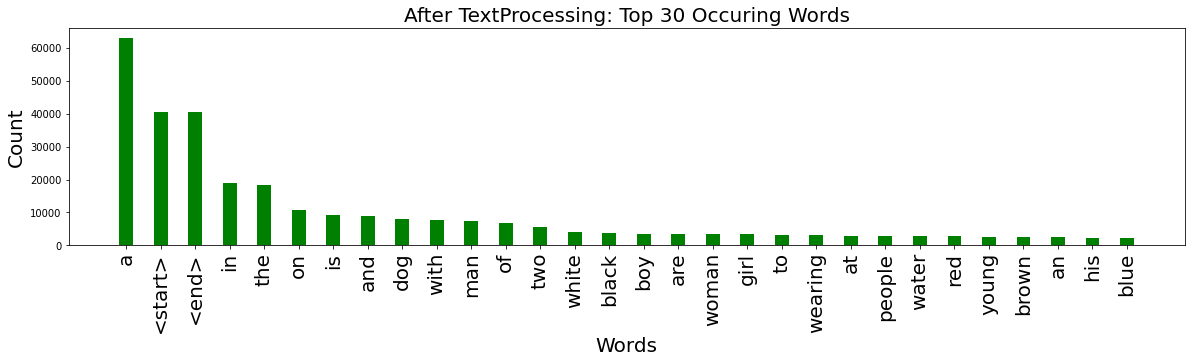

In [ ]:
word_counts = tokenizer.word_counts
df_word = pd.DataFrame.from_dict(word_counts, orient = 'index')
df_word = df_word.sort_values(by = [0], ascending=False).reset_index()
df_word = df_word.rename(columns={'index':'word', 0:'count'})

words = list(df_word[:30].word)
count =list(df_word['count'][:30])
plthist(list(range(0,30)),words,count, title='After TextProcessing: Top 30 Occuring Words')


Maximum Length of sequence

In [ ]:
max_len = max([len(cap) for cap in train_seqs])
print("shape of caption vector: ", len(train_seqs))
print("Maximum length of sequence: ",max_len)

shape of caption vector:  40455
Maximum length of sequence:  39


#### Pad each vector to the max_length of the captions and store it to a vairable

In [ ]:
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs,
                                                          padding='post',
                                                          maxlen=max_len)

print("The shape of Caption vector is :" + str(cap_vector.shape))
cap_vector

The shape of Caption vector is :(40455, 39)


array([[ 3,  2, 44, ...,  0,  0,  0],
       [ 3,  2, 20, ...,  0,  0,  0],
       [ 3,  2, 41, ...,  0,  0,  0],
       ...,
       [ 3,  2, 45, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0],
       [ 3,  2, 86, ...,  0,  0,  0]], dtype=int32)

### Pre-processing the images


#### Resize them into the shape of (299, 299)

In [ ]:
def preprocess_image(image_path, shape = (299, 299)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,shape)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

In [ ]:
print("Shape after resize :", preprocess_image(all_img_path[0])[0].shape)

Shape after resize : (299, 299, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


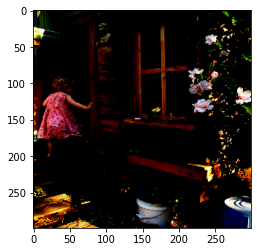

In [ ]:
plt.imshow(preprocess_image(all_img_path[0])[0])


3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

In [ ]:
encode_train_set = sorted(set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

### Create the train & test data

#### Create the train-test split using 80-20 ratio & random state = 42


In [ ]:
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,cap_vector,
                                                                        test_size=0.2,random_state=42)

In [ ]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [ ]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)


(32, 299, 299, 3)
(32,)


### Model Building

####  Load the pretrained Imagenet weights of Inception net V3


To save the RAM from getting exhausted, extract the features of the image using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  # get the input of the image_model
hidden_layer = image_model.layers[-1].output  # get the output of the image_model

image_features_extract_model = keras.Model(new_input, hidden_layer)  # build the final model using both input & output layer

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

#### Extract features from each image in the dataset

In [ ]:
feature_dict = {}
for image,path in tqdm(image_dataset):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████| 253/253 [19:38<00:00,  4.66s/it]


In [ ]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

In [ ]:
def generate_dataset(images_data, captions_data, BATCH_SIZE =32, BUFFER_SIZE = 1000):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

Training and testing dataset with extracted features and caption

In [ ]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


### Model Building


#### Set the parameters


In [ ]:
BATCH_SIZE = 32
embedding_dim = 256 
units = 512
vocab_size = 6001 #top 6,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

#### Encoder

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features) 
        features = tf.nn.relu(features)
        
        return features

In [ ]:
encoder=Encoder(embedding_dim)

#### Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis = 1) # reduce the shape to (batch_size, embedding_dim)
        
        return context_vector, attention_weights

#### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.dropout(self.embed(x)) # embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed, mask = mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 6001)
Attention weights shape from Decoder: (32, 64, 1)


### Model training & optimization


#### Set the optimizer & loss object

In [ ]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#### Create your checkpoint path


In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

#### Create your training & testing step functions

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss


#### Create your loss function for the test dataset

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    
    return avg_test_loss

##### Model Training

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.212, & test loss is 1.025
Time taken for 1 epoch 253.61758995056152 sec

Test loss has been reduced from 100.000 to 1.025


 10%|█         | 2/20 [06:30<1:05:36, 218.67s/it]

For epoch: 2, the train loss is 0.946, & test loss is 0.904
Time taken for 1 epoch 136.2851061820984 sec

Test loss has been reduced from 1.025 to 0.904
For epoch: 3, the train loss is 0.856, & test loss is 0.828
Time taken for 1 epoch 136.26254725456238 sec

Test loss has been reduced from 0.904 to 0.828


 15%|█▌        | 3/20 [08:46<54:58, 194.01s/it]  

For epoch: 4, the train loss is 0.793, & test loss is 0.769
Time taken for 1 epoch 136.53608918190002 sec

Test loss has been reduced from 0.828 to 0.769


 25%|██▌       | 5/20 [13:20<41:11, 164.80s/it]

For epoch: 5, the train loss is 0.740, & test loss is 0.719
Time taken for 1 epoch 136.515451669693 sec

Test loss has been reduced from 0.769 to 0.719
For epoch: 6, the train loss is 0.694, & test loss is 0.677
Time taken for 1 epoch 136.4476923942566 sec

Test loss has been reduced from 0.719 to 0.677


 30%|███       | 6/20 [15:36<36:29, 156.36s/it]

For epoch: 7, the train loss is 0.654, & test loss is 0.636
Time taken for 1 epoch 136.41845631599426 sec

Test loss has been reduced from 0.677 to 0.636


 40%|████      | 8/20 [20:09<29:13, 146.16s/it]

For epoch: 8, the train loss is 0.617, & test loss is 0.601
Time taken for 1 epoch 135.9878170490265 sec

Test loss has been reduced from 0.636 to 0.601


 45%|████▌     | 9/20 [22:26<26:15, 143.25s/it]

For epoch: 9, the train loss is 0.584, & test loss is 0.568
Time taken for 1 epoch 136.2399344444275 sec

Test loss has been reduced from 0.601 to 0.568
For epoch: 10, the train loss is 0.553, & test loss is 0.540
Time taken for 1 epoch 136.44128704071045 sec

Test loss has been reduced from 0.568 to 0.540


 55%|█████▌    | 11/20 [26:59<20:58, 139.87s/it]

For epoch: 11, the train loss is 0.524, & test loss is 0.514
Time taken for 1 epoch 136.40145921707153 sec

Test loss has been reduced from 0.540 to 0.514
For epoch: 12, the train loss is 0.500, & test loss is 0.489
Time taken for 1 epoch 136.3590133190155 sec

Test loss has been reduced from 0.514 to 0.489


 65%|██████▌   | 13/20 [31:32<16:07, 138.18s/it]

For epoch: 13, the train loss is 0.477, & test loss is 0.466
Time taken for 1 epoch 136.33731174468994 sec

Test loss has been reduced from 0.489 to 0.466
For epoch: 14, the train loss is 0.455, & test loss is 0.445
Time taken for 1 epoch 136.43658757209778 sec

Test loss has been reduced from 0.466 to 0.445


 70%|███████   | 14/20 [33:49<13:46, 137.71s/it]

For epoch: 15, the train loss is 0.436, & test loss is 0.428
Time taken for 1 epoch 136.31329941749573 sec

Test loss has been reduced from 0.445 to 0.428


 75%|███████▌  | 15/20 [36:05<11:26, 137.36s/it]

For epoch: 16, the train loss is 0.419, & test loss is 0.409
Time taken for 1 epoch 135.82257890701294 sec

Test loss has been reduced from 0.428 to 0.409


 85%|████████▌ | 17/20 [40:37<06:49, 136.64s/it]

For epoch: 17, the train loss is 0.403, & test loss is 0.395
Time taken for 1 epoch 135.67992401123047 sec

Test loss has been reduced from 0.409 to 0.395


 90%|█████████ | 18/20 [42:53<04:32, 136.39s/it]

For epoch: 18, the train loss is 0.389, & test loss is 0.383
Time taken for 1 epoch 135.59665751457214 sec

Test loss has been reduced from 0.395 to 0.383
For epoch: 19, the train loss is 0.377, & test loss is 0.369
Time taken for 1 epoch 135.86446690559387 sec

Test loss has been reduced from 0.383 to 0.369


100%|██████████| 20/20 [47:24<00:00, 142.24s/it]

For epoch: 20, the train loss is 0.363, & test loss is 0.356
Time taken for 1 epoch 135.06001234054565 sec

Test loss has been reduced from 0.369 to 0.356


#### Changing Epochs

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 30

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.355, & test loss is 0.345
Time taken for 1 epoch 135.11493039131165 sec

Test loss has been reduced from 100.000 to 0.345


  3%|▎         | 1/30 [02:15<1:05:24, 135.32s/it]

For epoch: 2, the train loss is 0.342, & test loss is 0.337
Time taken for 1 epoch 135.3096945285797 sec

Test loss has been reduced from 0.345 to 0.337


 10%|█         | 3/30 [06:46<1:00:58, 135.48s/it]

For epoch: 3, the train loss is 0.332, & test loss is 0.325
Time taken for 1 epoch 135.51608300209045 sec

Test loss has been reduced from 0.337 to 0.325


 13%|█▎        | 4/30 [09:01<58:42, 135.47s/it]  

For epoch: 4, the train loss is 0.324, & test loss is 0.319
Time taken for 1 epoch 135.2241916656494 sec

Test loss has been reduced from 0.325 to 0.319


 17%|█▋        | 5/30 [11:17<56:26, 135.48s/it]

For epoch: 5, the train loss is 0.318, & test loss is 0.311
Time taken for 1 epoch 135.30762887001038 sec

Test loss has been reduced from 0.319 to 0.311
For epoch: 6, the train loss is 0.310, & test loss is 0.303
Time taken for 1 epoch 134.9461555480957 sec

Test loss has been reduced from 0.311 to 0.303


 23%|██▎       | 7/30 [15:48<51:53, 135.39s/it]

For epoch: 7, the train loss is 0.302, & test loss is 0.296
Time taken for 1 epoch 135.19357466697693 sec

Test loss has been reduced from 0.303 to 0.296


 27%|██▋       | 8/30 [18:03<49:39, 135.42s/it]

For epoch: 8, the train loss is 0.297, & test loss is 0.290
Time taken for 1 epoch 135.29142880439758 sec

Test loss has been reduced from 0.296 to 0.290
For epoch: 9, the train loss is 0.290, & test loss is 0.285
Time taken for 1 epoch 135.3362467288971 sec

Test loss has been reduced from 0.290 to 0.285


 30%|███       | 9/30 [20:19<47:24, 135.46s/it]

For epoch: 10, the train loss is 0.285, & test loss is 0.279
Time taken for 1 epoch 135.45696830749512 sec

Test loss has been reduced from 0.285 to 0.279


 33%|███▎      | 10/30 [22:34<45:10, 135.53s/it]

For epoch: 11, the train loss is 0.280, & test loss is 0.274
Time taken for 1 epoch 135.11224460601807 sec

Test loss has been reduced from 0.279 to 0.274


 37%|███▋      | 11/30 [24:50<42:53, 135.46s/it]

For epoch: 12, the train loss is 0.275, & test loss is 0.267
Time taken for 1 epoch 135.45702409744263 sec

Test loss has been reduced from 0.274 to 0.267


 43%|████▎     | 13/30 [29:21<38:22, 135.44s/it]

For epoch: 13, the train loss is 0.271, & test loss is 0.268
Time taken for 1 epoch 135.23212552070618 sec



 47%|████▋     | 14/30 [31:36<36:06, 135.38s/it]

For epoch: 14, the train loss is 0.266, & test loss is 0.261
Time taken for 1 epoch 135.04053115844727 sec

Test loss has been reduced from 0.267 to 0.261


 50%|█████     | 15/30 [33:51<33:51, 135.46s/it]

For epoch: 15, the train loss is 0.261, & test loss is 0.255
Time taken for 1 epoch 135.44824862480164 sec

Test loss has been reduced from 0.261 to 0.255


 53%|█████▎    | 16/30 [36:07<31:37, 135.56s/it]

For epoch: 16, the train loss is 0.260, & test loss is 0.253
Time taken for 1 epoch 135.5779504776001 sec

Test loss has been reduced from 0.255 to 0.253


 57%|█████▋    | 17/30 [38:23<29:22, 135.54s/it]

For epoch: 17, the train loss is 0.255, & test loss is 0.247
Time taken for 1 epoch 135.31047296524048 sec

Test loss has been reduced from 0.253 to 0.247


 60%|██████    | 18/30 [40:38<27:06, 135.56s/it]

For epoch: 18, the train loss is 0.251, & test loss is 0.246
Time taken for 1 epoch 135.427875995636 sec

Test loss has been reduced from 0.247 to 0.246


 63%|██████▎   | 19/30 [42:54<24:50, 135.47s/it]

For epoch: 19, the train loss is 0.248, & test loss is 0.243
Time taken for 1 epoch 135.0589838027954 sec

Test loss has been reduced from 0.246 to 0.243


 67%|██████▋   | 20/30 [45:09<22:35, 135.50s/it]

For epoch: 20, the train loss is 0.244, & test loss is 0.240
Time taken for 1 epoch 135.3819499015808 sec

Test loss has been reduced from 0.243 to 0.240


 70%|███████   | 21/30 [47:25<20:19, 135.49s/it]

For epoch: 21, the train loss is 0.242, & test loss is 0.237
Time taken for 1 epoch 135.26763224601746 sec

Test loss has been reduced from 0.240 to 0.237
For epoch: 22, the train loss is 0.239, & test loss is 0.235
Time taken for 1 epoch 135.0573422908783 sec

Test loss has been reduced from 0.237 to 0.235


 77%|███████▋  | 23/30 [51:55<15:48, 135.43s/it]

For epoch: 23, the train loss is 0.238, & test loss is 0.230
Time taken for 1 epoch 135.24488806724548 sec

Test loss has been reduced from 0.235 to 0.230


 80%|████████  | 24/30 [54:10<13:32, 135.34s/it]

For epoch: 24, the train loss is 0.234, & test loss is 0.230
Time taken for 1 epoch 135.13786697387695 sec



 83%|████████▎ | 25/30 [56:26<11:17, 135.43s/it]

For epoch: 25, the train loss is 0.232, & test loss is 0.225
Time taken for 1 epoch 135.44901633262634 sec

Test loss has been reduced from 0.230 to 0.225


 87%|████████▋ | 26/30 [58:41<09:01, 135.36s/it]

For epoch: 26, the train loss is 0.231, & test loss is 0.222
Time taken for 1 epoch 134.9880542755127 sec

Test loss has been reduced from 0.225 to 0.222


 90%|█████████ | 27/30 [1:00:57<06:46, 135.42s/it]

For epoch: 27, the train loss is 0.228, & test loss is 0.223
Time taken for 1 epoch 135.5672745704651 sec



 93%|█████████▎| 28/30 [1:03:12<04:30, 135.44s/it]

For epoch: 28, the train loss is 0.227, & test loss is 0.219
Time taken for 1 epoch 135.2893750667572 sec

Test loss has been reduced from 0.222 to 0.219


 97%|█████████▋| 29/30 [1:05:28<02:15, 135.39s/it]

For epoch: 29, the train loss is 0.222, & test loss is 0.216
Time taken for 1 epoch 135.07461190223694 sec

Test loss has been reduced from 0.219 to 0.216


100%|██████████| 30/30 [1:07:43<00:00, 135.44s/it]

For epoch: 30, the train loss is 0.223, & test loss is 0.217
Time taken for 1 epoch 135.18292498588562 sec



##### Visualize the loss for training and testing

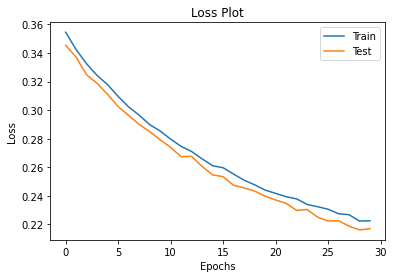

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(["Train", "Test"], loc ="best")
plt.show()

### Model Evaluation



#### Define your evaluation function using greedy search

In [ ]:
def evaluate(image):
    max_length=max_len
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

##### Defining a function for a resized image plotting as a part of output 

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

### Bleu

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

#### Evaluating the model performance
We would choose random image from the test dataset using randint function

##### Iteration 1

Real Caption      : a gray terrier runs in a snow covered field
Prediction Caption: a gray terrier runs in an winter field



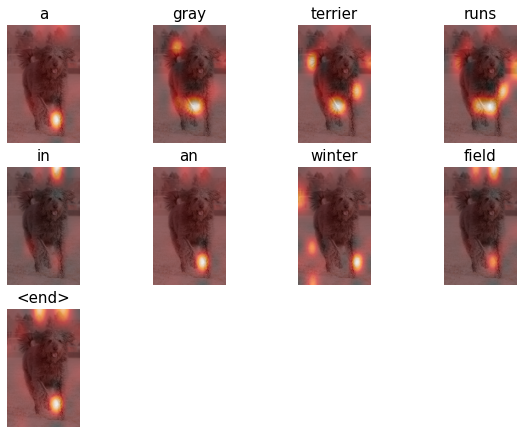

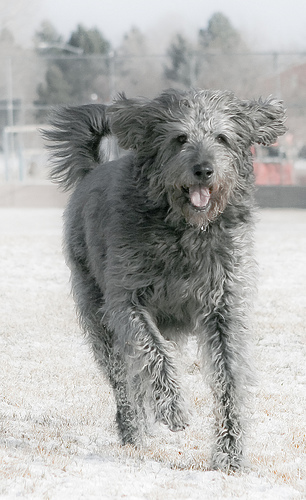

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

##### Iteration 2

Real Caption      : man carves block of ice with a saw
Prediction Caption: a man carves block of ice with a saw



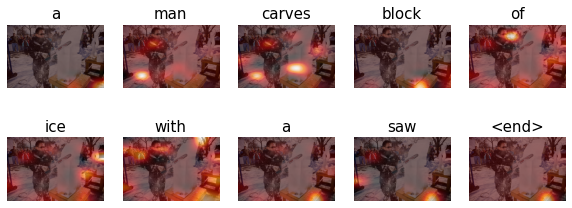

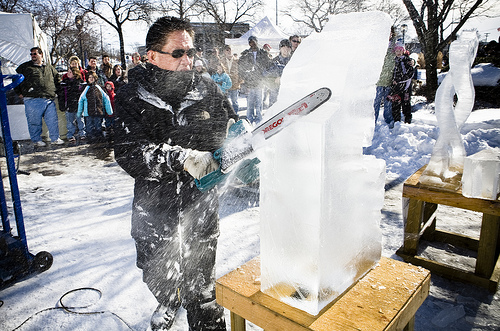

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

Real Caption      : man carves block of ice with a saw
Prediction Caption: a man carves block of ice with a saw

BELU score: 
Individual 1-gram: 88.88888888888889
Individual 2-gram: 87.5
Individual 3-gram: 85.71428571428571
Individual 4-gram: 83.33333333333334


In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

BELU score: 
Cumumlative 1-gram: 88.88888888888889
Cumumlative 2-gram: 88.19171036881968
Cumumlative 3-gram: 87.47619509674372
Cumumlative 4-gram: 86.33400213704505


##### Iteration 3

Real Caption      : a man is looking down
Prediction Caption: a man in sunglasses and leather jacket looking down



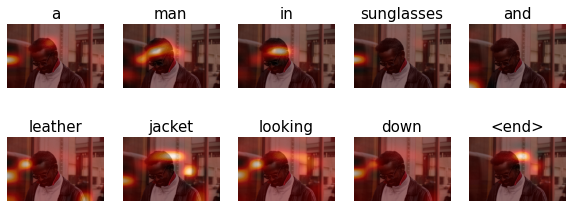

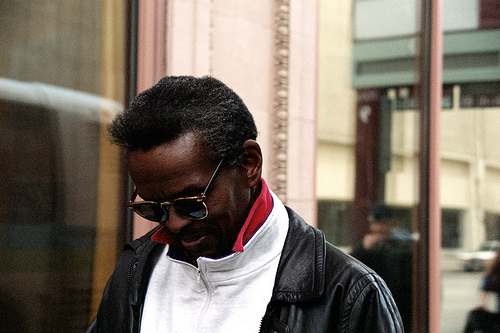

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

Real Caption      : a man is looking down
Prediction Caption: a man in sunglasses and leather jacket looking down

BELU score: 
Individual 1-gram: 44.44444444444444
Individual 2-gram: 25.0
Individual 3-gram: 100.0
Individual 4-gram: 100.0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

BELU score: 
Cumumlative 1-gram: 44.44444444444444
Cumumlative 2-gram: 33.333333333333336
Cumumlative 3-gram: 48.42838338767059
Cumumlative 4-gram: 57.73502691896258


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


##### Iteration

Real Caption      : a man is watching a dog catch a frisbee in midair
Prediction Caption: a man tossing a frisbee in midair



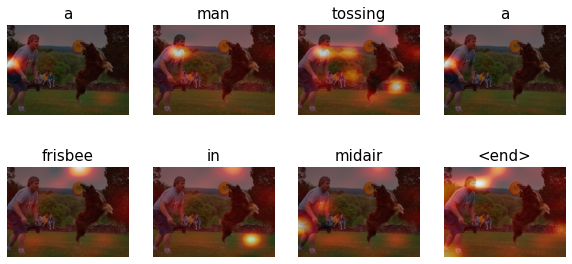

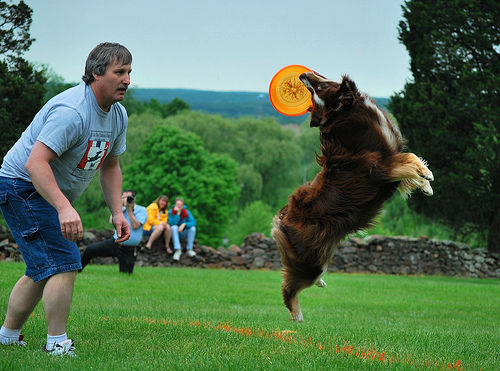

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

Real Caption      : a man is watching a dog catch a frisbee in midair
Prediction Caption: a man tossing a frisbee in midair

BELU score: 
Individual 1-gram: 48.404410457807934
Individual 2-gram: 37.647874800517286
Individual 3-gram: 22.588724880310373
Individual 4-gram: 14.117953050193982


In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

BELU score: 
Cumumlative 1-gram: 48.404410457807934
Cumumlative 2-gram: 42.68867747668464
Cumumlative 3-gram: 34.698361368304866
Cumumlative 4-gram: 27.610369103579487


##### Iteration 4

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)
Image.open(test_image)

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

##### Iteration 5

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

##### Iteration 6

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

##### Iteration 7:
False Positive

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

##### Iteration 7:

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

##### Iteration 8:

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

##### Iteration 9

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

##### Iteration 10

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")

##### Iteration 11

In [ ]:
rid = np.random.randint(0, len(image_test))
test_image = image_test[rid]
# test_image = './images/413231421_43833a11f5.jpg'
# real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)
real_caption=filt_text(real_caption)      
pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)
print ('')
plot_attmap(result, attention_plot, test_image)

Image.open(test_image)

In [ ]:
print ('Real Caption      :', real_caption)
print ('Prediction Caption:', pred_caption)

score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))

print("\nBELU score: ")
print(f"Individual 1-gram: {score1*100}")
print(f"Individual 2-gram: {score2*100}")
print(f"Individual 3-gram: {score3*100}")
print(f"Individual 4-gram: {score4*100}")

In [ ]:
score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
score2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
score3 = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33,0))
score4 = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))

print(f"BELU score: ")
print(f"Cumumlative 1-gram: {score1*100}")
print(f"Cumumlative 2-gram: {score2*100}")
print(f"Cumumlative 3-gram: {score3*100}")
print(f"Cumumlative 4-gram: {score4*100}")